# Sheet 9

In [1]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset, DataLoader

## 1 Jet-Tagging with PyTorch
(a)

In [2]:
# load the dijet data
features = np.load('data/dijet_features_normalized.npy').T
labels = np.load('data/dijet_labels.npy')

# shuffle the data
order = np.arange(len(labels))
np.random.seed(0)
np.random.shuffle(order)
features = features[order]
labels = labels[order]

n_features = features.shape[1]
print(n_features)
print(f'{features.shape=}, {labels.shape=}')

# TODO: create train, val and test splits
test_features  = torch.tensor(features[:200,:]).to(torch.float32)
val_features   = torch.tensor(features[200:400,:]).to(torch.float32)
train_features = torch.tensor(features[400:,:]).to(torch.float32)

test_labels    = torch.tensor(labels[:200].astype(float)).to(torch.long)
val_labels     = torch.tensor(labels[200:400].astype(float)).to(torch.long)
train_labels   = torch.tensor(labels[400:].astype(float)).to(torch.long)

#print(test_features.shape, train_features.shape,val_features.shape)
# TODO: create the datsets
testdata  = TensorDataset(test_features,  test_labels)
valdata   = TensorDataset(val_features,   val_labels)
traindata = TensorDataset(train_features, train_labels)

116
features.shape=(2233, 116), labels.shape=(2233,)


(b)

In [3]:
# TODO: Instantiate an MLP as specified
from torchvision.ops import MLP

mlp = MLP(116, [128,128,128,128,116])

(c)

In [4]:
# TODO: create the optimizer
optimizer = Adam(mlp.parameters(), lr=1e-4)

import torch.nn as nn
# TODO: create the criterion
criterion = nn.CrossEntropyLoss()

(d)

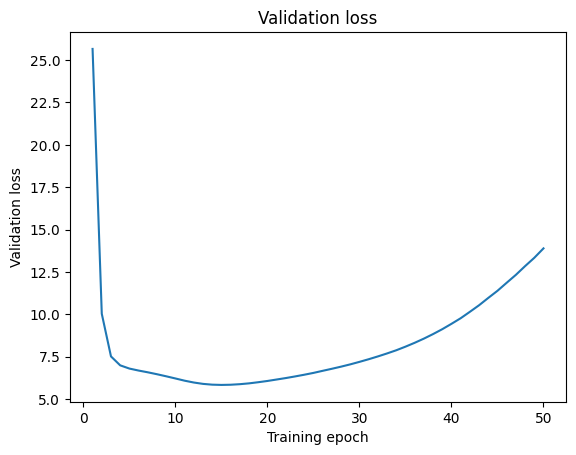

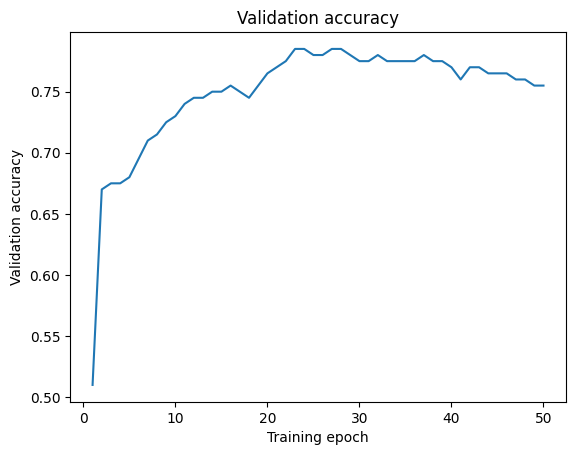

In [5]:
# TODO: create the data loaders, use a batch size of 16
test_loader  = torch.utils.data.DataLoader(testdata, batch_size=16,
                                         shuffle=False, num_workers=4)
train_loader = torch.utils.data.DataLoader(traindata, batch_size=16,
                                         shuffle=False, num_workers=4)
val_loader   = torch.utils.data.DataLoader(valdata, batch_size=16,
                                         shuffle=False, num_workers=4)

# TODO: Implement the training loop, validating after every epoch and keeping track of losses and accuracies
n_epochs = 50
losses = np.zeros(n_epochs)
accuracies = np.zeros(n_epochs)

for epoch in range(n_epochs):
    for i, (x, y) in enumerate(train_loader):
        #TODO: train step
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = mlp(x)
        loss = criterion(output, y)
        
        loss.backward()
        optimizer.step()
    # TODO: validate
    with torch.no_grad():
        running_loss = 0
        correct = 0
        total = 0
        for i, (x, y) in enumerate(val_loader):
            output = mlp(x)
            loss = criterion(output, y)
            running_loss += loss.item()
            total += y.size(0)
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == y).sum().item()
        losses[epoch] = running_loss
        accuracies[epoch] = correct/total
        if running_loss < np.max(losses):
            #save net
            torch.save(mlp.state_dict(), './data/mlp.pth')
    #print(f'Epoch {epoch+1} had loss {losses[epoch]} and accuracy {100*accuracies[epoch]}%.')

# TODO: Plot the losses and accuracies.
epochs = np.arange(n_epochs)+1
plt.plot(epochs, losses)
plt.title('Validation loss')
plt.xlabel('Training epoch')
plt.ylabel('Validation loss')
plt.show()
plt.plot(epochs, accuracies)
plt.title('Validation accuracy')
plt.xlabel('Training epoch')
plt.ylabel('Validation accuracy')
plt.show()

(e)

In [6]:
# TODO: load the best model and evaluate it on the test set
bestmlp = MLP(116, [128,128,128,128,116])
bestmlp.load_state_dict(torch.load('./data/mlp.pth'))

with torch.no_grad():
        running_loss = 0
        correct = 0
        total = 0
        for i, (x, y) in enumerate(train_loader):
            output = bestmlp(x)
            loss = criterion(output, y)
            running_loss += loss.item()
            total += y.size(0)
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == y).sum().item()
        print('For the training dataset, we got a loss of: {:.2f} and an accuracy of {:.1f}%.'.format(running_loss, correct/total*100))

For the training dataset, we got a loss of: 6.63 and an accuracy of 97.7%.


(f)

In [7]:
# TODO: experiment with some hyperparameters and discuss your results


## Task 2: CNNs for Galaxy Classification

Read through and run the cells below to get started

In [8]:
# download the data 
# it's ~200MB, might take some time depending on your internet speed

#import urllib.request
#_, msg = urllib.request.urlretrieve(
#    "http://www.astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5", 
#    "data/Galaxy10.h5"
#)
#print(msg)

In [9]:
import h5py
import numpy as np
import torch

label_names = [
    'Disk, Face-on, No Spiral',
    'Smooth, Completely round',
    'Smooth, in-between round',
    'Smooth, Cigar shaped',
    'Disk, Edge-on, Rounded Bulge',
    'Disk, Edge-on, Boxy Bulge',
    'Disk, Edge-on, No Bulge',
    'Disk, Face-on, Tight Spiral',
    'Disk, Face-on, Medium Spiral',
    'Disk, Face-on, Loose Spiral'
]
n_classes = len(label_names)

# To get the images and labels from file
with h5py.File('data/Galaxy10.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])
with h5py.File('data/Galaxy10_compressed.h5', 'w') as f:
    f.create_dataset('images', data=images.astype(np.float16), compression='gzip')
    f.create_dataset('ans', data=labels.astype(np.int32), compression='gzip')
#assert False
images = images.astype(np.float32)

# comply to (batch, channel, height, width) convention of pytorch
images = np.moveaxis(images, -1, 1)  
# convert to torch
images = torch.from_numpy(images)
labels = torch.from_numpy(labels)

print(f'{images.shape=}, {labels.shape=}')

print(labels.shape, images.shape)
print(f'\nNumber of samples per class:')
for label, count in zip(*np.unique(labels, return_counts=True)):
    print(f'{label_names[label]:40s}: {count}')

images.shape=torch.Size([21785, 3, 69, 69]), labels.shape=torch.Size([21785])
torch.Size([21785]) torch.Size([21785, 3, 69, 69])

Number of samples per class:
Disk, Face-on, No Spiral                : 3461
Smooth, Completely round                : 6997
Smooth, in-between round                : 6292
Smooth, Cigar shaped                    : 349
Disk, Edge-on, Rounded Bulge            : 1534
Disk, Edge-on, Boxy Bulge               : 17
Disk, Edge-on, No Bulge                 : 589
Disk, Face-on, Tight Spiral             : 1121
Disk, Face-on, Medium Spiral            : 906
Disk, Face-on, Loose Spiral             : 519


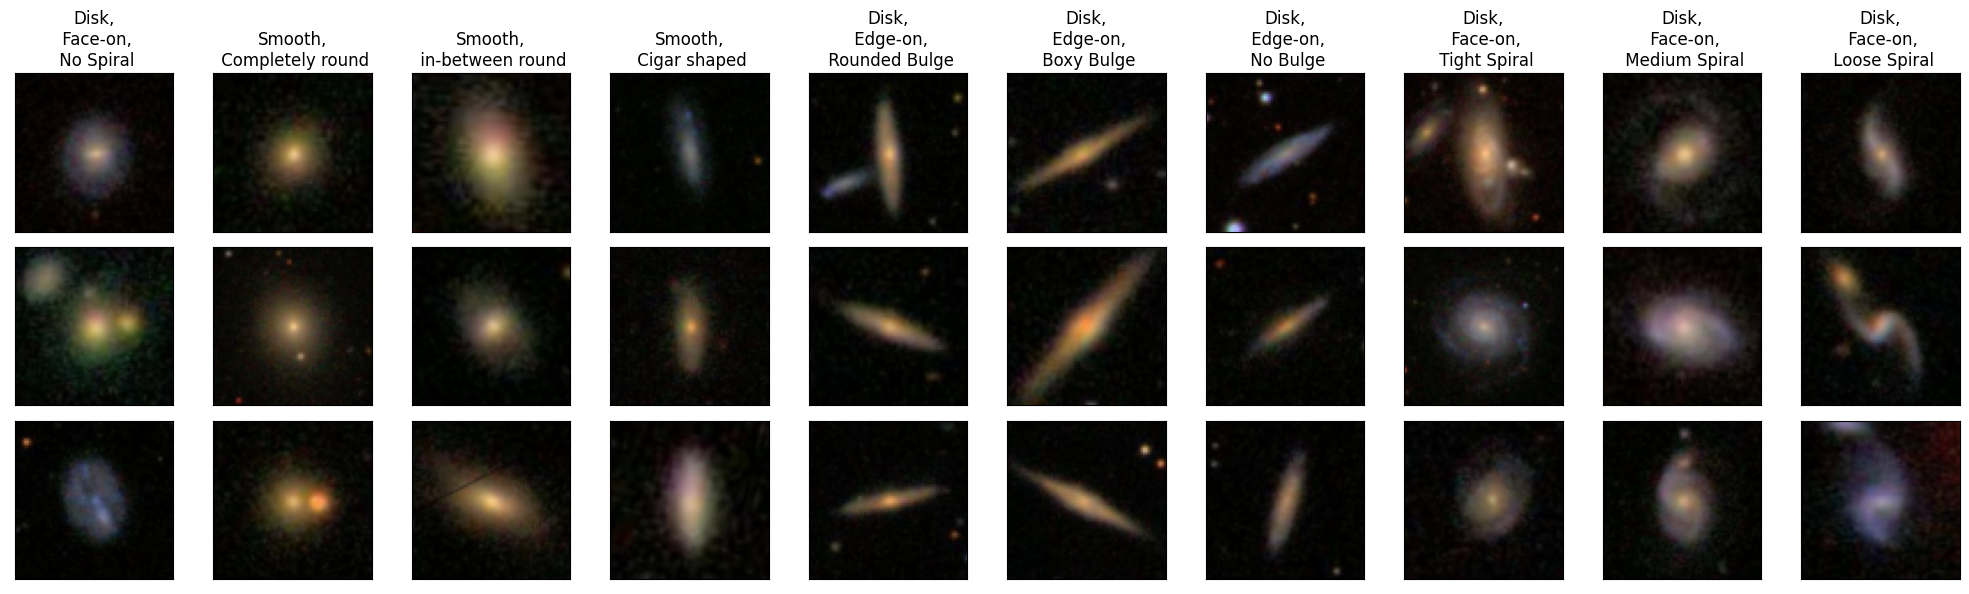

In [10]:
from matplotlib import pyplot as plt

# plot some samples of each class
itemindex = torch.where(labels == 3)
itemindex[:3]

samples_per_class = 3
fig, axss = plt.subplots(samples_per_class, n_classes, figsize=(n_classes * 2, samples_per_class * 2))
for label, (label_name, axs) in enumerate(zip(label_names, axss.T)):
    idx = torch.where(labels==label)[0][:samples_per_class] # take samples_per_class first occurences
    for i, (ind, ax) in enumerate(zip(idx, axs)):
        ax.imshow(images[ind].long().moveaxis(0, -1))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == 0:
            ax.set_title(label_name.replace(',',',\n'))
plt.tight_layout()
plt.show()

In [11]:
from torchvision.transforms import Normalize

# Compute the mean and standard deviation per channel over the dataset
# stds = images.moveaxis(1, 0).reshape(3, -1).std(axis=1)
# means = images.moveaxis(1, 0).reshape(3, -1).mean(axis=1)

# Use precomputed means and stds
stds, means = torch.tensor([37.5412, 31.3756, 26.3283]), torch.tensor([27.7014, 23.8241, 18.1425])

# TODO: Normalize the images
normalize = Normalize(means, stds)
images_normalized = normalize(images)

In [12]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

n_samples = len(labels)

# split the data in training and validation sets, stratifying by the labels
train_idx, val_idx = train_test_split(np.arange(n_samples), test_size=0.1, stratify=labels)

# create pytorch datasets for training and validation
train_dataset = TensorDataset(images_normalized[train_idx].float(), labels[train_idx].long())
val_dataset = TensorDataset(images_normalized[val_idx].float(), labels[val_idx].long())

(a)

In [13]:
import torch.nn as nn
import torch.nn.functional as F

#TODO: implement a small CNN as specified on the sheet
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # convolution layers as described
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.conv2 = nn.Conv2d(8, 16, 5)
        # an affine operation: y = Wx + b
        self.mlp = mlp = MLP(16*14*14, [64,32,n_classes])

    def forward(self, x):
        # Max pooling over a (2, 2) window
        #print('0', x.shape)
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        #print('1', x.shape)
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        #print('2', x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        #print('3', x.shape)
        x = self.mlp(x)
        #print('4', x.shape)
        return x


cnn = CNN()

(b)

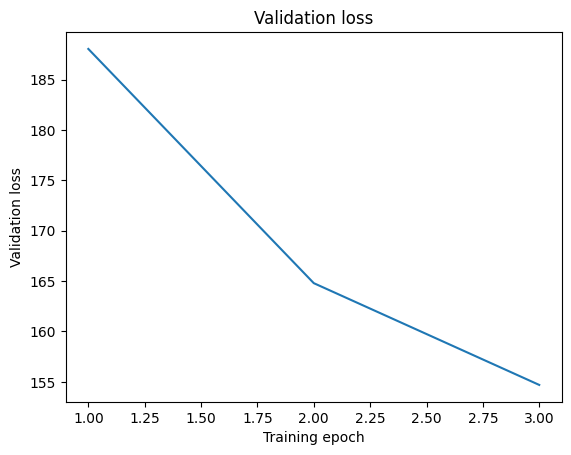

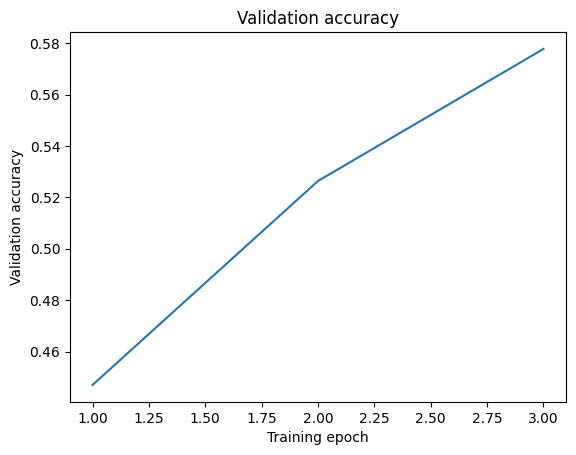

In [14]:
# TODO: create DataLoaders for train and val, use a batch size of 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16,
                                         shuffle=False, num_workers=4)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=16,
                                         shuffle=False, num_workers=4)
# TODO: instantiate the model, optimizer and criterion
optimizer = Adam(cnn.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
# TODO: implement the training loop, validating after every epoch, and make the requested plots
n_epochs = 3
losses = np.zeros(n_epochs)
accuracies = np.zeros(n_epochs)

for epoch in range(n_epochs):
    for i, (x, y) in enumerate(train_loader):
        #TODO: train step
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = cnn(x)
        loss = criterion(output, y)
        
        loss.backward()
        optimizer.step()
        if (i+1)% 136 == 0:
            print(f'epoch {epoch+1}: {(i+1)*1600/21785:.1f}% done', end='\r')
    # TODO: validate
    with torch.no_grad():
        running_loss = 0
        correct = 0
        total = 0
        for i, (x, y) in enumerate(val_loader):
            output = cnn(x)
            loss = criterion(output, y)
            running_loss += loss.item()
            total += y.size(0)
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == y).sum().item()
        losses[epoch] = running_loss
        accuracies[epoch] = correct/total
        
epochs = np.arange(n_epochs)+1
plt.plot(epochs, losses)
plt.title('Validation loss')
plt.xlabel('Training epoch')
plt.ylabel('Validation loss')
plt.show()
plt.plot(epochs, accuracies)
plt.title('Validation accuracy')
plt.xlabel('Training epoch')
plt.ylabel('Validation accuracy')
plt.show()

#TODO confusion matrix

In [15]:
from sklearn.metrics import confusion_matrix
true_labels = np.array(1)
pred_labels = np.array(1)
for i, (x, y) in enumerate(val_loader):
    output = cnn(x)
    loss = criterion(output, y)
    running_loss += loss.item()
    total += y.size(0)
    _, predicted = torch.max(output.data, 1)
    correct += (predicted == y).sum().item()
    true_labels = np.append(true_labels, y.numpy())
    pred_labels = np.append(pred_labels, predicted.numpy())
    #if len(true_labels) != len(pred_labels):
    #    print(i, len(true_labels), len(pred_labels), true_labels,pred_labels)
    losses[epoch] = running_loss
    accuracies[epoch] = correct/total

<AxesSubplot: >

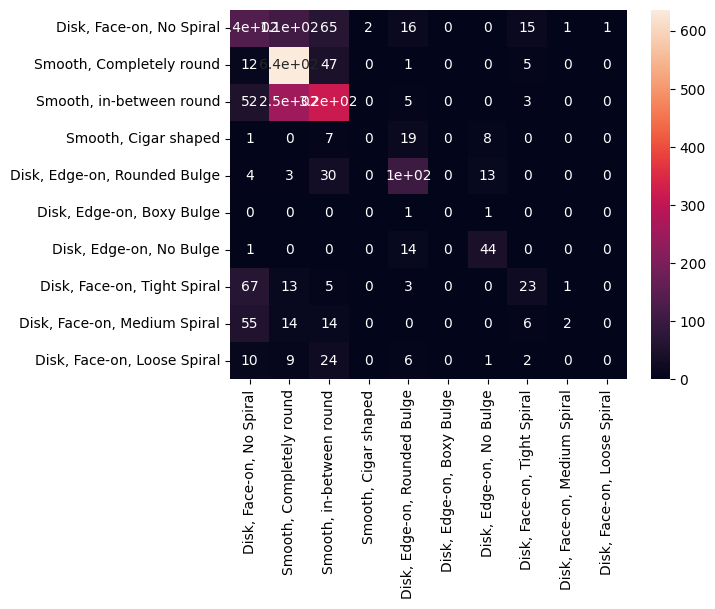

In [16]:
#plt.matshow([[12,2],[4,15]])
import seaborn as sns

sns.heatmap(confusion_matrix(true_labels, pred_labels),annot=True, xticklabels=label_names, yticklabels=label_names)

# https://stackoverflow.com/a/35572247

(c)

In [17]:
# TODO: redo (c) with a ResNet
# Hint: Training is probably quicker on google colab (https://colab.research.google.com/)
from torchvision.models import resnet34
resn = resnet34()

resn.fc = nn.Linear(resn.fc.in_features, n_classes)

In [18]:
# TODO: create DataLoaders for train and val, use a batch size of 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16,
                                         shuffle=False, num_workers=4)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=16,
                                         shuffle=False, num_workers=4)
# TODO: instantiate the model, optimizer and criterion
optimizer = Adam(resn.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
# TODO: implement the training loop, validating after every epoch, and make the requested plots
n_epochs = 3
losses = np.zeros(n_epochs)
accuracies = np.zeros(n_epochs)

for epoch in range(n_epochs):
    for i, (x, y) in enumerate(train_loader):
        #TODO: train step
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = resn(x)
        loss = criterion(output, y)
        
        loss.backward()
        optimizer.step()
        if (i+1)% 136 == 0:
            print(f'epoch {epoch+1}: {(i+1)*1600/21785:.1f}% done', end='\r')
    # TODO: validate
    with torch.no_grad():
        running_loss = 0
        correct = 0
        total = 0
        for i, (x, y) in enumerate(val_loader):
            output = resn(x)
            loss = criterion(output, y)
            running_loss += loss.item()
            total += y.size(0)
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == y).sum().item()
        losses[epoch] = running_loss
        accuracies[epoch] = correct/total
        
epochs = np.arange(n_epochs)+1
plt.plot(epochs, losses)
plt.title('Validation loss')
plt.xlabel('Training epoch')
plt.ylabel('Validation loss')
plt.show()
plt.plot(epochs, accuracies)
plt.title('Validation accuracy')
plt.xlabel('Training epoch')
plt.ylabel('Validation accuracy')
plt.show()

from sklearn.metrics import confusion_matrix
true_labels = np.array(1)
pred_labels = np.array(1)
for i, (x, y) in enumerate(val_loader):
    output = cnn(x)
    loss = criterion(output, y)
    running_loss += loss.item()
    total += y.size(0)
    _, predicted = torch.max(output.data, 1)
    correct += (predicted == y).sum().item()
    true_labels = np.append(true_labels, y.numpy())
    pred_labels = np.append(pred_labels, predicted.numpy())
    #if len(true_labels) != len(pred_labels):
    #    print(i, len(true_labels), len(pred_labels), true_labels,pred_labels)
    losses[epoch] = running_loss
    accuracies[epoch] = correct/total
    
sns.heatmap(confusion_matrix(true_labels, pred_labels),annot=True, xticklabels=label_names, yticklabels=label_names)

KeyboardInterrupt: 